In [1]:
import numpy as np
import pandas as pd
import os
import warnings
import random
warnings.filterwarnings("ignore")

from PIL import Image
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.pyplot as plt
import cv2

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE, LocallyLinearEmbedding, MDS
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score, accuracy_score, adjusted_rand_score, normalized_mutual_info_score
from matplotlib.ticker import FixedLocator, FixedFormatter
from scipy.spatial import procrustes
from scipy.stats import mode
from sklearn.mixture import GaussianMixture

from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

## Section1

Total number of components to preserve 90% of variance is 212

In [3]:
def read_files(folder_path, image_data, categories, file_names):
    # Set a random seed for reproducibility
    random.seed(42)

    for i in os.listdir(folder_path):
        sub_folder_path = os.path.join(folder_path, i)
        jpg_files = [f for f in os.listdir(sub_folder_path) if f.endswith('.jpg')]
        sampled_files = random.sample(jpg_files, min(int(len(jpg_files)/8), len(jpg_files)))
        for file in sampled_files:
            file_names.append(file)
            file_path = os.path.join(sub_folder_path, file)
            try:
                # Read the image with OpenCV
                img = cv2.imread(file_path)
                if img is not None:
                    image_data.append(img)
                    categories.append(i)
                else:
                    print(f"Failed to read {file}")
            except Exception as e:
                print(f"Error reading {file}: {e}")
    return image_data, categories, file_names

In [4]:
folder_path = r'C:\Users\mohit\OneDrive\Desktop\IUB\Applied ML\Assignment 3\rgb-train\train'
train_image_data = []
train_categories = []
train_file_names = []

# Read train data
train_image_data, train_categories, file_names = read_files(folder_path, train_image_data, train_categories, train_file_names)
train_image_data = [img.flatten() for img in train_image_data]
print(f"Successfully read {len(train_image_data)} images.")

# Convert list to 2D numpy array
image_data = np.array(train_image_data)

# Standardize the data
scaler = StandardScaler()
image_data_scaled = scaler.fit_transform(image_data)

Successfully read 1000 images.


In [5]:
# Perform PCA
pca = PCA(n_components=0.90)  # Retain 90% of the variance
pca.fit(image_data_scaled)

# Number of components to retain 90% variance
n_components = pca.n_components_
print(f"Number of components to retain 90% variance: {n_components}")

# Transformed data
image_data_pca = pca.transform(image_data_scaled)
print(f"Shape of transformed data: {image_data_pca.shape}")

Number of components to retain 90% variance: 212
Shape of transformed data: (1000, 212)


## Section 2

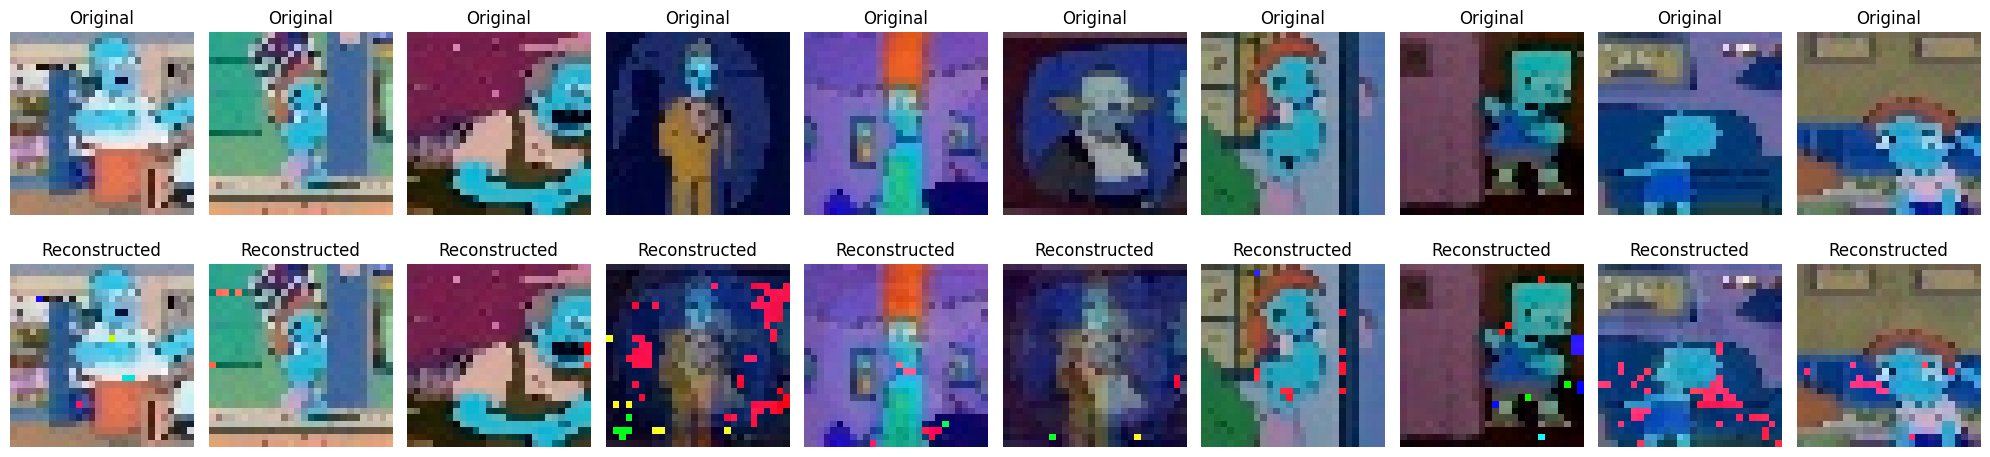

In [ ]:
# Randomly select 10 images
random_indices = np.random.choice(len(image_data), size=10, replace=False)
random_images = np.array(image_data)[random_indices]

# Flatten images into 1D vectors
flattened_images = random_images.reshape(len(random_images), -1)  # (num_images, 28*28*3)

# Standardize the data
scaler = StandardScaler()
flattened_images_scaled = scaler.fit_transform(flattened_images)

# Perform PCA to retain 90% variance
pca = PCA(n_components=0.90)
flattened_images_pca = pca.fit_transform(flattened_images_scaled)

# Reconstruct images
reconstructed_images = pca.inverse_transform(flattened_images_pca)

# Undo standardization for reconstruction
reconstructed_images = scaler.inverse_transform(reconstructed_images)

# Reshape reconstructed images back to original dimensions (28, 28, 3 for RGB)
original_shape = (28, 28, 3)  # RGB images
reconstructed_images = reconstructed_images.reshape(-1, *original_shape)
random_images = random_images.reshape(-1, *original_shape)  # Ensure original images are reshaped too

# Plot original and reconstructed images
fig, axes = plt.subplots(2, 10, figsize=(20, 5))

for i in range(10):
    # Plot original images
    axes[0, i].imshow(random_images[i].astype(np.uint8))
    axes[0, i].axis("off")
    axes[0, i].set_title("Original")

    # Plot reconstructed images
    axes[1, i].imshow(reconstructed_images[i].astype(np.uint8))
    axes[1, i].axis("off")
    axes[1, i].set_title("Reconstructed")

plt.tight_layout()
plt.show()

## Section 3

### Part A

In [ ]:
pca_2 = PCA(n_components=2)  # Reduce to 2 dimensions
pca_result = pca_2.fit_transform(image_data_scaled)

In [ ]:
# Get the explained variance ratio for the first two principal components
explained_variance_ratio = pca_2.explained_variance_ratio_
print(f"Explained variance ratio by the first two principal components: {explained_variance_ratio}")
print(f"Total variance explained: {explained_variance_ratio.sum()}")

Explained variance ratio by the first two principal components: [0.24250448 0.05218037]
Total variance explained: 0.2946848499442753


### Part B

In [13]:
unique_categories = np.unique(train_categories)
categories1 = np.array(train_categories)

In [ ]:
# Define the function to add images to the scatter plot
def add_images_to_plot(ax, images, points, image_size=50, zoom=0.75):
    for i in range(len(points)):
        x, y = points[i]
        image = images[i]
        imgbox = AnnotationBbox(
            OffsetImage(image, zoom=zoom),
            (x, y),
            frameon=False
        )
        ax.add_artist(imgbox)

In [ ]:
def scatter_plot_overlay(model_result, unique_categories, categories, model_name, image_data, jpg_files):
    # Load your PCA results and categories
    # Assuming pca_result is a numpy array with 2D PCA-transformed data
    # Assuming categories is a list or numpy array of category labels
    # Assuming image_data contains file paths or PIL images

    # Generate the scatter plot
    plt.figure(figsize=(10, 8))
    ax = plt.gca()

    # Plot each category
    for category in unique_categories:
        category_indices = np.where(categories == category)[0]
        plt.scatter(
            model_result[category_indices, 0],
            model_result[category_indices, 1],
            label=f"Category {category}",
            s=100, alpha=0.7
        )

    np.random.seed(42)
    # Load and prepare the images for overlay
    selected_indices = np.random.choice(len(image_data), size=15, replace=False)
    selected_images = [Image.open(os.path.join(folder_path, categories[i], jpg_files[i])) for i in selected_indices]
    selected_points = model_result[selected_indices]

    # Overlay the images
    add_images_to_plot(ax, selected_images, selected_points)

    # Finalize the plot
    plt.title(f"{model_name} Visualization of Rock Images with Overlays")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.legend()
    plt.grid()
    plt.show()

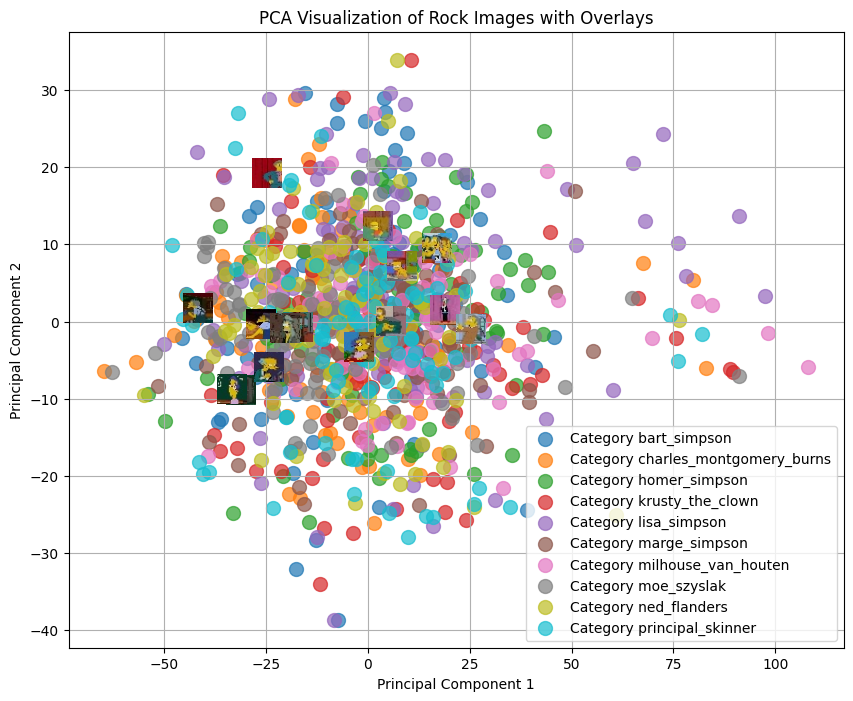

In [ ]:
scatter_plot_overlay(pca_result, unique_categories, categories1, 'PCA', image_data , train_file_names)

In [ ]:
tsne_2 = TSNE(n_components=2, random_state=0)
tsne_result = tsne_2.fit_transform(image_data_scaled)

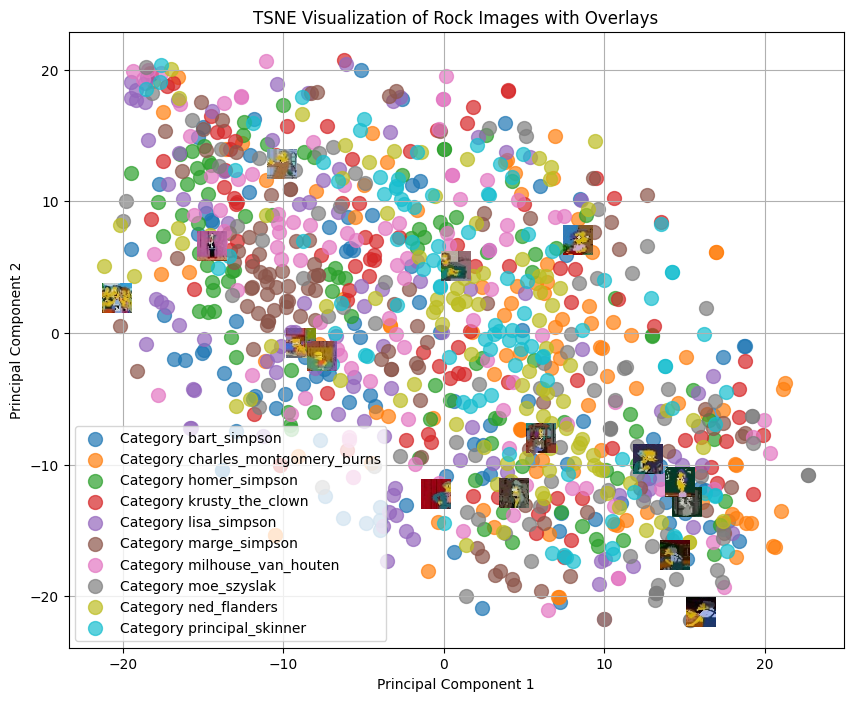

In [ ]:
scatter_plot_overlay(tsne_result, unique_categories, categories1, "TSNE", image_data , train_file_names)

In [ ]:
lle_2 = LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=0)
lle_result = lle_2.fit_transform(image_data)

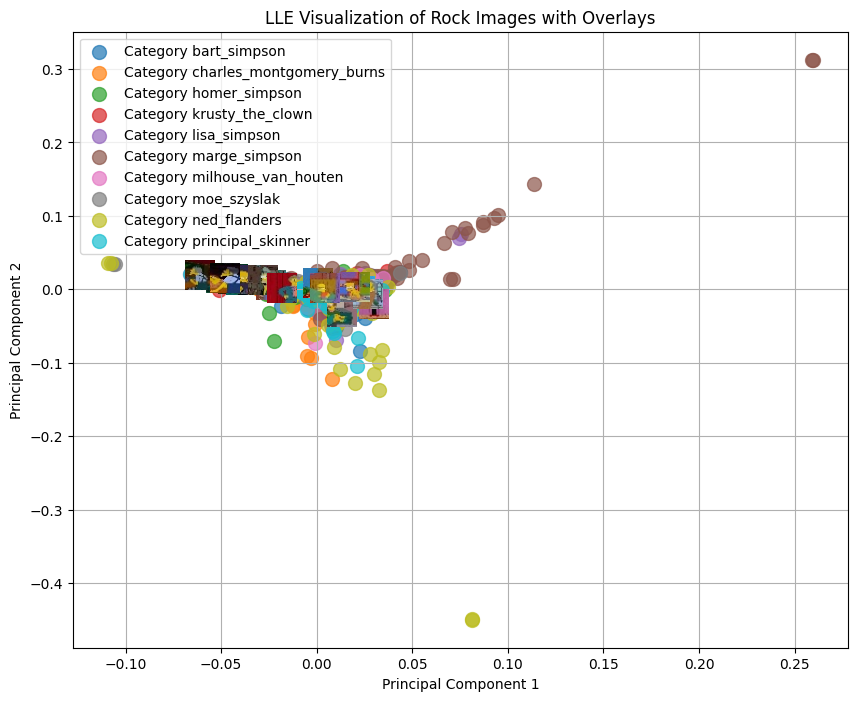

In [ ]:
scatter_plot_overlay(lle_result, unique_categories, categories1, "LLE", image_data , train_file_names)

In [ ]:
mds = MDS(n_components=2, random_state=0)
mds_result = mds.fit_transform(image_data_scaled)

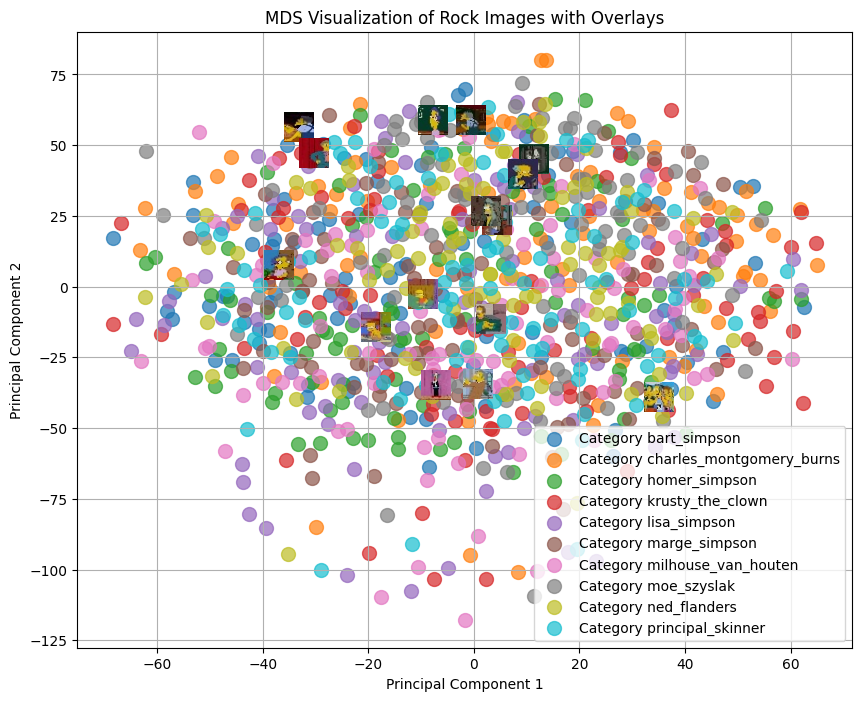

In [ ]:
scatter_plot_overlay(mds_result, unique_categories, categories1, "MDS", image_data , train_file_names)

### Part C

Clustering techniques observations:
1. PCA Visualization
*   Shows a scattered distribution with points spread across both positive and negative values on both axes
*   Data points form a roughly circular cloud with some outliers
*   Character categories show significant overlap in the center
*   Some clustering is visible but boundaries between categories are not distinct
*   Range approximately -50 to 100 on PC1 and -40 to 35 on PC2
2. t-SNE Visualization
*   Exhibits more defined local structure compared to PCA
*   Creates several small clusters and subgroups
*   Shows better separation between some character categories
*   Data points spread more evenly across the visualization space
*   Range approximately -20 to 20 on both axes
*   Preserves local relationships better than PCA
3. LLE Visualization
* Shows the most compact representation of all methods
* Data points are highly concentrated around the origin
* Very small scale (-0.4 to 0.3 on PC2, -0.1 to 0.25 on PC1)
* Few outliers visible, particularly in the positive PC1 direction
* Less effective at separating different character categories
4. MDS Visualization
* Similar overall structure to PCA but different scale
* Points distributed in a roughly circular pattern
* Large spread of values (-125 to 75 on PC2, -60 to 60 on PC1)
* Shows global structure preservation
* Character categories show significant overlap
* Maintains relative distances between points better than t-SNE

Final Observations:


1.   PCA and MDS show similar broad, circular distributions with data points spread widely across both axes
2.   t-SNE creates more localized clusters while maintaining some global structure
3. LLE produces the most condensed visualization with most points tightly clustered near the origin
4. t-SNE provides the best separation between different character groups



## Section 5

### Part A

Looking at both the silhouette plots and the silhouette score graph, k=2 appears to be the optimal number of clusters for this dataset for several reasons:
1. The silhouette score graph shows the highest score (approximately 0.13) at k=2, with a clear downward trend as k increases.
2. In the silhouette coefficient plots:
* The k=2 plot shows more consistent and higher positive values across clusters
* As k increases, the silhouette coefficients generally become smaller and more variable
* Higher k values (8-10) show many clusters with very thin or negative silhouette values, indicating poor clustering

In [21]:
# Applying PCA to reduce dimentions and preserve 90% variance
pca_clustering = PCA(n_components = 0.90)
image_data_pca = pca_clustering.fit_transform(image_data)

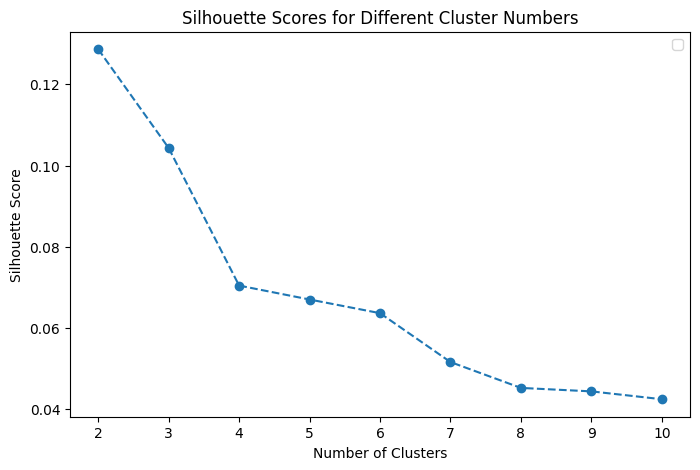

In [ ]:
# Use silhouette score to find the optimal number of clusters
silhouette_scores = []
k_values = range(2, 11)
for k in k_values:
    cluster = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster.fit(image_data_pca)
    silhouette_scores.append(silhouette_score(image_data_pca, cluster.labels_))

# Plot silhouette scores
plt.figure(figsize=(8, 5))
plt.plot(k_values, silhouette_scores, marker='o', linestyle='--')
plt.title('Silhouette Scores for Different Cluster Numbers')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.legend()
plt.show()

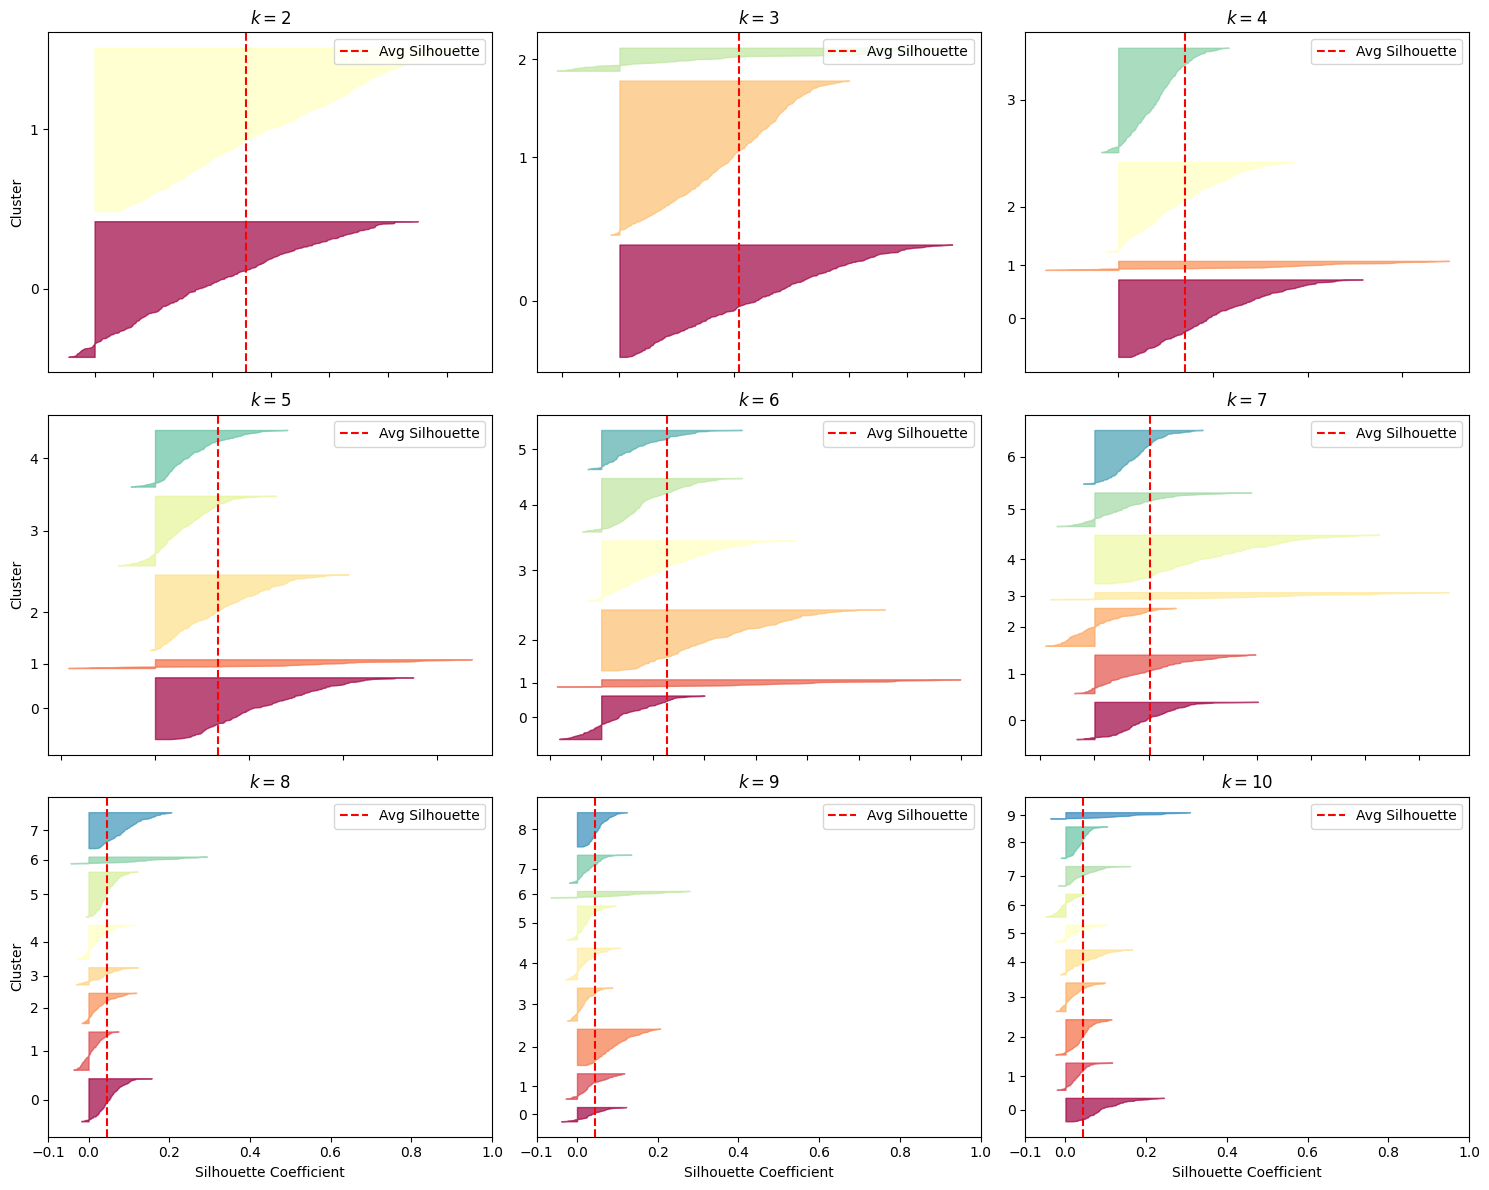

In [ ]:
# Assuming `image_data_pca`, `k_values`, `silhouette_scores`, and KMeans clustering are already defined
kmeans_per_k = [KMeans(n_clusters=k, random_state=42, n_init=10).fit(image_data_pca) for k in k_values]

plt.figure(figsize=(15, 12))  # Adjusted figure size for better clarity

for idx, k in enumerate(k_values, start=1):
    plt.subplot(3, 3, idx)  # Dynamically create subplots for all k_values
    y_pred = kmeans_per_k[idx - 1].labels_
    silhouette_coefficients = silhouette_samples(image_data_pca, y_pred)

    padding = len(image_data_pca) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = plt.cm.Spectral(i / k)  # Use the Spectral colormap for distinct cluster colors
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))

    if idx % 3 == 1:  # Add ylabel to the leftmost plots
        plt.ylabel("Cluster")
    if idx > len(k_values) - 3:  # Add xlabel to bottom row plots
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[idx - 1], color="red", linestyle="--", label="Avg Silhouette")
    plt.title(f"$k={k}$")
    plt.legend(loc="upper right")

# Save and show the figure
plt.tight_layout()
plt.savefig("silhouette_analysis_plot.png", dpi=300)
plt.show()

### Part B

* Used 10 clusters as there are 10 categories
* The accuracy of model is pretty low (20%) but is better than a random guess (10% probability)

In [9]:
def clustering_accuracy(clustering_results, numeric_labels, true_labels, unique_labels, k):
    # Map clusters to actual labels using mode
    label_mapping = {}
    for i in range(k):  # Iterate over clusters
        cluster_indices = np.where(clustering_results == i)
        most_common_label = mode(numeric_labels[cluster_indices])[0]
        label_mapping[i] = most_common_label

    # Map predicted cluster labels to their corresponding true labels
    predicted_labels_numeric = np.array([label_mapping[cluster] for cluster in clustering_results])

    # Convert numeric predictions back to original string labels
    predicted_labels = unique_labels[predicted_labels_numeric]

    # Calculate clustering accuracy
    accuracy = accuracy_score(true_labels, predicted_labels)
    ari_score = adjusted_rand_score(numeric_labels, clustering_results)  # Adjusted Rand Index
    nmi_score = normalized_mutual_info_score(numeric_labels, clustering_results)  # Normalized Mutual Information

    return accuracy, ari_score, nmi_score

In [15]:
# Map predicted clusters to true labels
unique_labels, numeric_labels = np.unique(categories1, return_inverse=True)

In [ ]:
# Run K-Means with 3 clusters
kmeans_10 = KMeans(n_clusters=10, random_state=42, n_init=10)
kmeans_clusters_10 = kmeans_10.fit_predict(image_data_pca)

In [ ]:
# Calculate accuracy
kmeans_accuracy, kmeans_ari_score, kmeans_nmi_score  = clustering_accuracy(kmeans_clusters_10, numeric_labels, categories1, unique_labels, 10)

In [ ]:
print("Accuracy of the model:", kmeans_accuracy)
print("ARI score:", kmeans_ari_score)
print("NMI score:", kmeans_nmi_score)

Accuracy of the model: 0.203
ARI score: 0.028309632082360342
NMI score: 0.07097641867577664


## Section 6

### Part A
The optimal number of clusters appears to be 3, as this represents:
* A local minimum in the BIC score, which is particularly important as BIC penalizes model complexity more heavily
* A reasonable point in the AIC curve before the continuous decrease
While the AIC continues to decrease with more clusters, this likely indicates overfitting.

The BIC's more pronounced minimum at 3 clusters provides a more reliable indicator for model selection, as it better balances model complexity with goodness of fit.

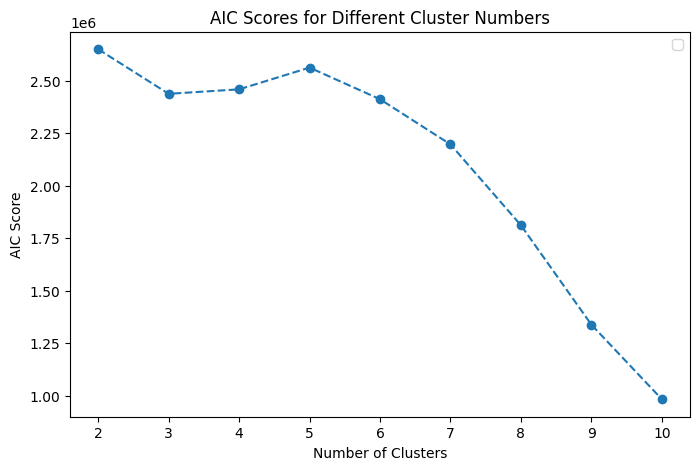

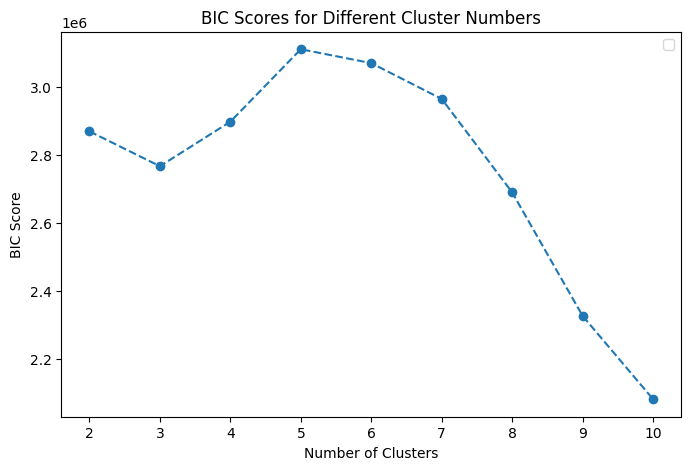

In [ ]:
# Use AIC and BIC score to find the optimal number of clusters
aic_scores = []
bic_scores = []
k_values = range(2, 11)
for k in k_values:
    em_cluster = GaussianMixture(n_components=k, random_state=42)
    em_cluster.fit(image_data_pca)
    aic_scores.append(em_cluster.aic(image_data_pca))
    bic_scores.append(em_cluster.bic(image_data_pca))

# Plot silhouette scores
plt.figure(figsize=(8, 5))
plt.plot(k_values, aic_scores, marker='o', linestyle='--')
plt.title('AIC Scores for Different Cluster Numbers')
plt.xlabel('Number of Clusters')
plt.ylabel('AIC Score')
plt.legend()
plt.show()

# Plot silhouette scores
plt.figure(figsize=(8, 5))
plt.plot(k_values, bic_scores, marker='o', linestyle='--')
plt.title('BIC Scores for Different Cluster Numbers')
plt.xlabel('Number of Clusters')
plt.ylabel('BIC Score')
plt.legend()
plt.show()

### Part B

* Used 10 clusters as there are 10 categories
* The accuracy of model is pretty low (19%) but is better than a random guess (10% probability)

In [23]:
# Run K-Means with 10 clusters
em_10 = GaussianMixture(n_components=10, random_state=42)
em_clusters_10 = em_10.fit_predict(image_data_pca)

In [24]:
# Calculate accuracy
em_accuracy, em_ari_score, em_nmi_score  = clustering_accuracy(em_clusters_10, numeric_labels, categories1, unique_labels, 10)

In [25]:
print("Accuracy of the model:", em_accuracy)
print("ARI score:", em_ari_score)
print("NMI score:", em_nmi_score)

Accuracy of the model: 0.19
ARI score: 0.021483773928775547
NMI score: 0.06136181013930697


### Part C

* As the accuracy is pretty low and quality of input images is also not great the sample pictures which are generated aren't great
* The generated images also indicate that model might be overfit to the train data

In [26]:
# Generate 20 new samples
generated_rocks, _ = em_10.sample(n_samples=20)

# Transforming rocks into the original space
generated_rocks_original_space = pca_clustering.inverse_transform(generated_rocks)

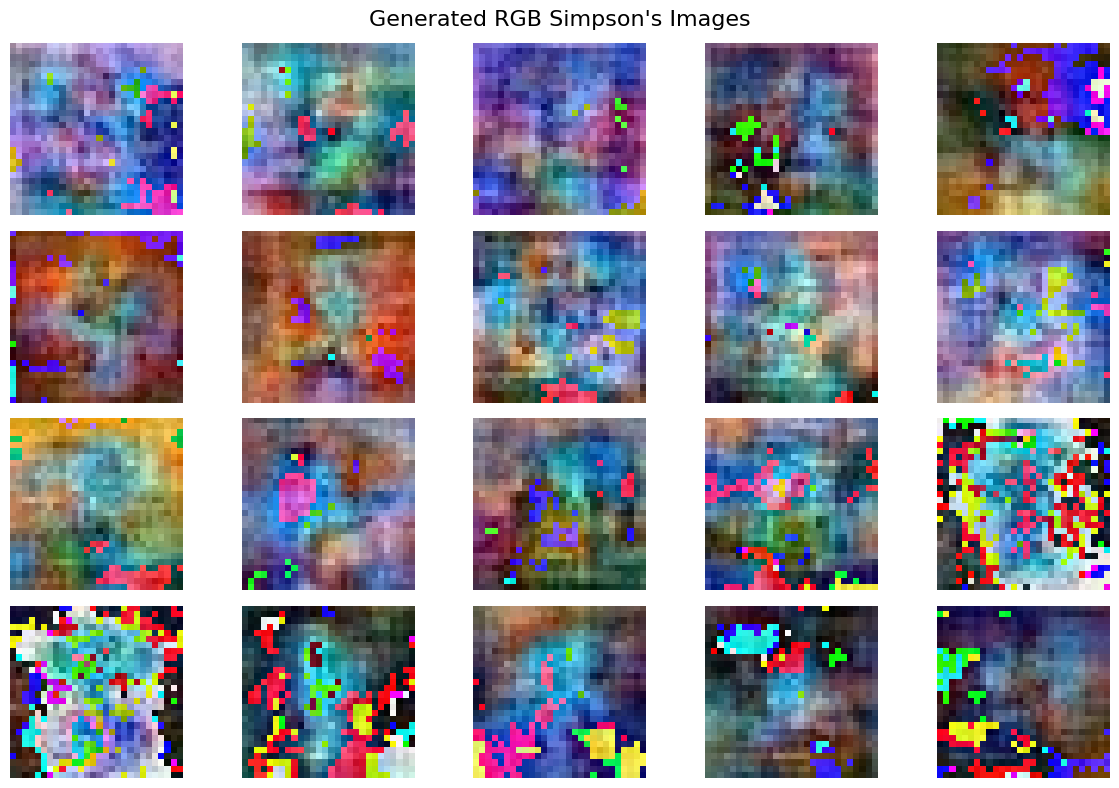

In [27]:
# Assuming `generated_rocks_original_space` is already loaded
image_height = 28
image_width = 28
num_channels = 3  # RGB images

# Determine the valid number of images
num_images = generated_rocks_original_space.size // (image_height * image_width * num_channels)

# Truncate the data to match the valid size if necessary
valid_size = num_images * image_height * image_width * num_channels
generated_rocks_original_space = generated_rocks_original_space[:valid_size]

# Reshape the data for RGB images
generated_images = generated_rocks_original_space.reshape((num_images, image_height, image_width, num_channels))

# Plot the images in a grid
num_cols = 5  # Number of columns in the grid
num_rows = (num_images + num_cols - 1) // num_cols  # Calculate rows dynamically

fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))
axes = axes.flatten()

for i in range(len(generated_images)):
    # Plot RGB image
    axes[i].imshow(generated_images[i].astype('uint8'))  # Ensure proper data type for display
    axes[i].axis('off')  # Turn off axes for a cleaner look

# Hide any remaining empty subplots
for j in range(len(generated_images), len(axes)):
    axes[j].axis('off')

plt.suptitle("Generated RGB Simpson's Images", fontsize=16)
plt.tight_layout()
plt.show()

## Question 7

In [ ]:
train_folder_path = '/content/drive/MyDrive/rgb-train/train'
train_image_data = []
train_categories = []
train_file_names = []

# Read train data
train_image_data, train_categories, file_names = read_files(train_folder_path, train_image_data, train_categories, train_file_names)
print(f"Successfully read {len(train_image_data)} images.")

Successfully read 1000 images.


In [ ]:
test_folder_path = '/content/drive/MyDrive/rgb-test/test'
test_image_data = []
test_categories = []
test_file_names = []

# Read test data
test_image_data, test_categories, file_names = read_files(test_folder_path, test_image_data, test_categories, test_file_names)
print(f"Successfully read {len(test_image_data)} images.")

Successfully read 250 images.


In [ ]:
def process_data(image_data, categories, classes):
    X_var = np.array(image_data)
    # Reshape, resize, and normalize the data
    X_var_resized = np.array([cv2.resize(img.reshape(28, 28, 3), (224, 224)) for img in X_var])
    X_var_resized = X_var_resized / 255.0
    category_to_int = {category: idx for idx, category in enumerate(np.unique(categories))}
    mapped_categories = np.array([category_to_int[category] for category in categories])
    y_var = to_categorical(mapped_categories, num_classes=classes)
    return X_var_resized, y_var

In [ ]:
X_train, y_train = process_data(train_image_data, train_categories, 10)
X_test, y_test = process_data(test_image_data, test_categories, 10)

In [ ]:
input_layer = layers.Input(shape=(224, 224, 3))

x = layers.Conv2D(32, (3, 3), activation='relu')(input_layer)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(128, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(256, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Flatten()(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(256, activation='relu')(x)
the_layer = layers.Dense(8, activation='relu', name='the_layer')(x)
output_layer = layers.Dense(10, activation='softmax')(the_layer)

model = models.Model(inputs=input_layer, outputs=output_layer)

activation_model = models.Model(inputs=model.input, outputs=model.get_layer('the_layer').output)

model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
import time

In [ ]:
start_time = time.time()
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=150, restore_best_weights=True, verbose=1)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
history = model.fit(
    X_train, y_train,
    epochs=1000,
    validation_data=(X_test, y_test),
    batch_size=32,
    callbacks=[lr_scheduler, early_stopping, checkpoint]
)
end_time = time.time()
training_time = end_time - start_time
print(f"Total training time: {training_time:.2f} seconds")

Epoch 1/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.1104 - loss: 2.3101
Epoch 1: val_accuracy improved from -inf to 0.16000, saving model to best_model.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 24s 396ms/step - accuracy: 0.1105 - loss: 2.3098 - val_accuracy: 0.1600 - val_loss: 2.2478 - learning_rate: 0.0010
Epoch 2/1000
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.1460 - loss: 2.2523
Epoch 2: val_accuracy improved from 0.16000 to 0.19600, saving model to best_model.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 23s 110ms/step - accuracy: 0.1470 - loss: 2.2518 - val_accuracy: 0.1960 - val_loss: 2.1834 - learning_rate: 0.0010
Epoch 3/1000
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.2046 - loss: 2.1412
Epoch 3: val_accuracy improved from 0.19600 to 0.26000, saving model to best_model.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step - accuracy: 0.2053 - loss: 2.1400 - val_accuracy: 0.2600 - val_loss: 2.0551 - learning_rate: 0.0010
Epoch 4/1000
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/s

In [ ]:
best_model = load_model('best_model.keras')
val_accuracy = best_model.evaluate(X_test, y_test, verbose=0)[1]
print(f"Highest validation accuracy: {val_accuracy*100:.4f}")

Highest validation accuracy: 48.0000


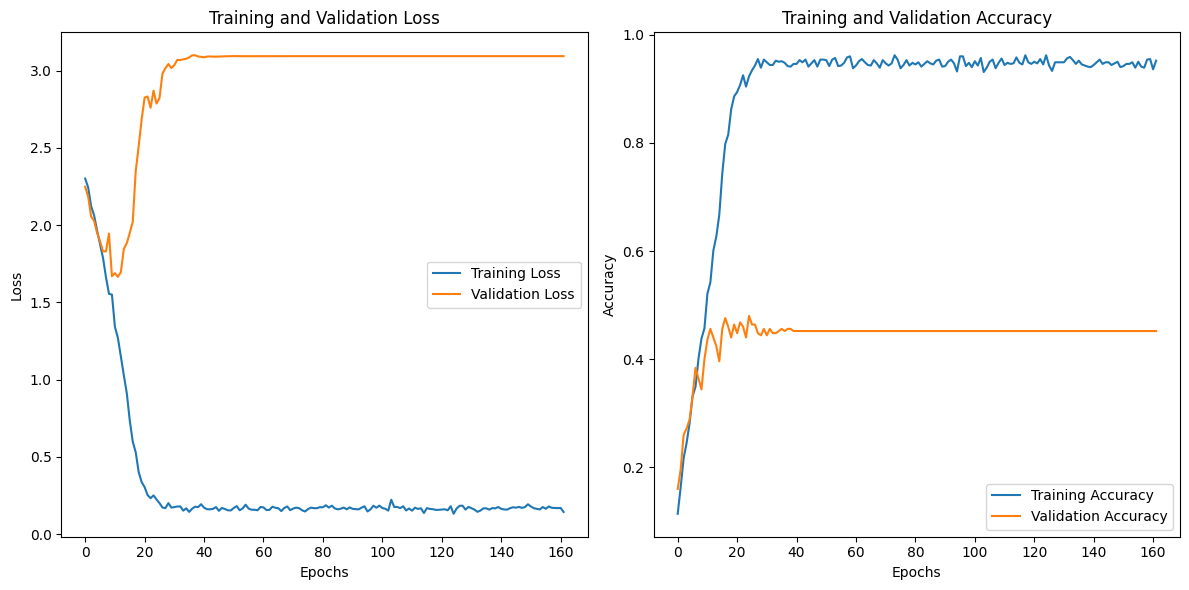

In [ ]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
total_params = 0
bias_params = 0
for layer in model.layers:
    layer_params = layer.count_params()
    total_params += layer_params
    if hasattr(layer, 'bias') and layer.bias is not None:
        bias_params += layer.bias.shape[0]
print(f"Total Parameters: {total_params}")
print(f"Total Bias Parameters: {bias_params}")

Total Parameters: 19396770
Total Bias Parameters: 1266
